### Acknowledgment

Some explanations, derivations, and formatting guidance in this notebook were assisted by OpenAI's ChatGPT. All code and final written content have been reviewed, tested, and edited for accuracy by me.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

## Load and Inspect the Dataset

In [2]:
# Load the dataset
file_path = "song_data.csv"  # Replace with your dataset path
song_data = pd.read_csv(file_path)

# Display basic information about the dataset
print(song_data.info())

# Check for missing values
print(song_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB
None
song_name           0
son

## Clean the Data

In [3]:
# Drop rows with missing values in selected features
selected_features = ['song_popularity', 'danceability', 'energy', 'acousticness', 'tempo']
cleaned_data = song_data[selected_features].dropna()
numeric_data = song_data.select_dtypes(include=['float64', 'int64'])

# Confirm the data is clean
print(cleaned_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   song_popularity  18835 non-null  int64  
 1   danceability     18835 non-null  float64
 2   energy           18835 non-null  float64
 3   acousticness     18835 non-null  float64
 4   tempo            18835 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 735.9 KB
None


## Create Visualizations

### Distribution of Song Popularity

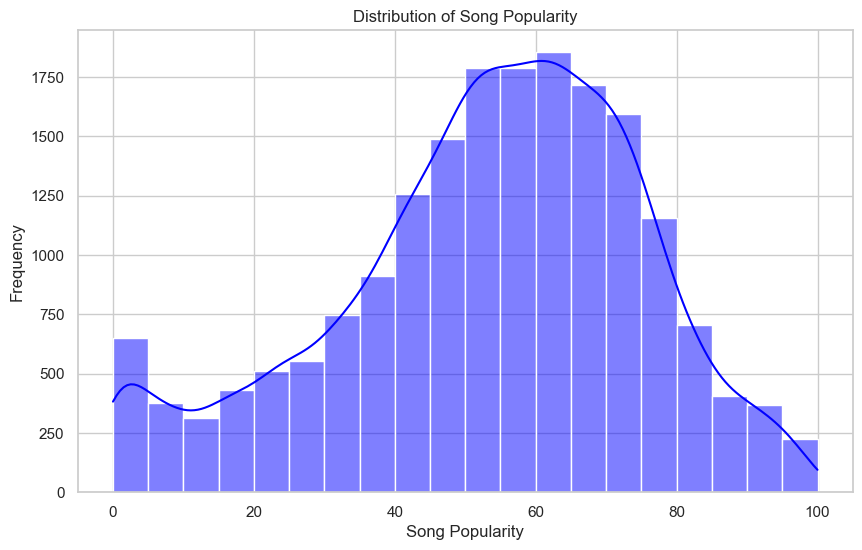

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(song_data['song_popularity'], kde=True, bins=20, color="blue")
plt.title("Distribution of Song Popularity")
plt.xlabel("Song Popularity")
plt.ylabel("Frequency")
plt.show()

1. **Why this visualization was chosen:**  
   A histogram was selected to display the distribution of song popularity scores. It allows us to see how popularity is spread across the dataset, highlighting any skewness or clustering.

2. **Why it’s significant for the task at hand:**  
   Understanding the distribution of popularity scores helps identify whether the data is balanced or skewed, which is critical for modeling and analysis. It also highlights the prevalence of high or low popularity songs.

3. **What we see from the result of the visualization:**  
   - The popularity scores are left-skewed, with the mean below the median.
   - there is a slight peak in the 0 popularity, maybe that will distort the model.
   - This indicates that most songs are more popular then average, a small subset pulls the average down, which could influence feature selection and model training.

### Correlation Heatmap

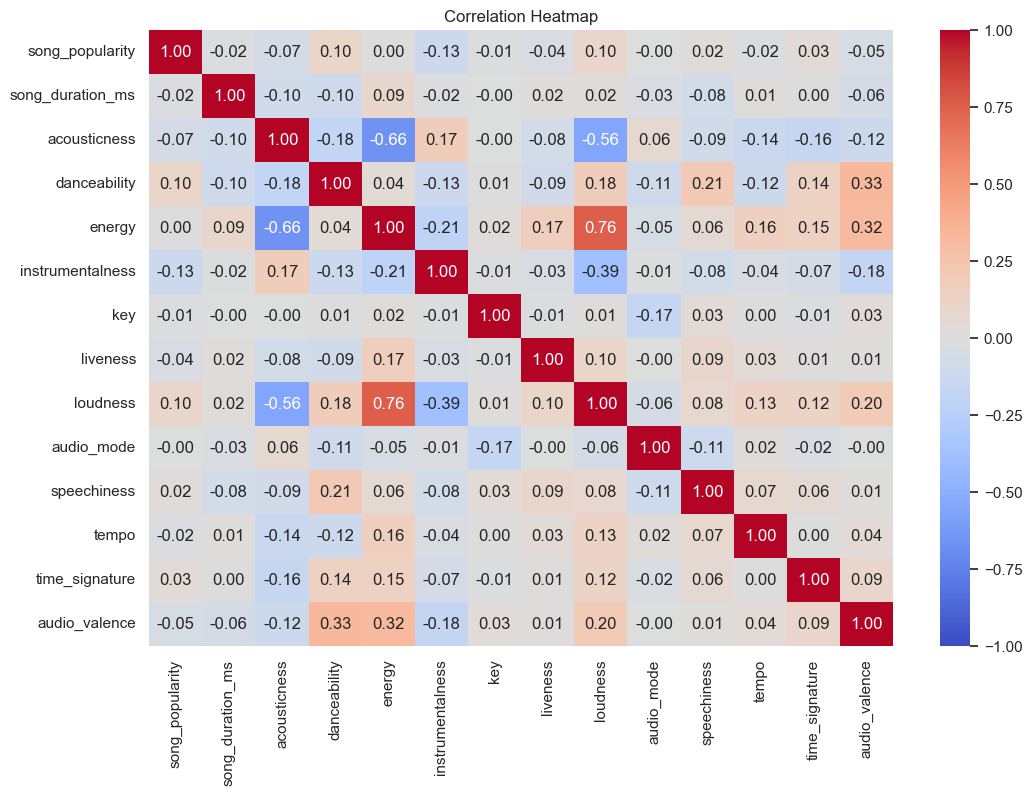

In [5]:
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

1. **Why this visualization was chosen:**  
   A heatmap was chosen to visually represent the pairwise correlations between numerical features in the dataset. It provides an intuitive way to understand relationships, helping identify features with strong positive or negative associations.

2. **Why it’s significant for the task at hand:**  
   Understanding feature correlations is crucial for feature selection and engineering. Highly correlated features can guide decisions on which variables might be most predictive of song popularity or avoid multicollinearity issues in modeling.

3. **What we see from the result of the visualization:**  
   - All features have relatively weak correlation with `song_popularity`.
   - The biggest positive correlation is with `loudness` and `danceability`. The biggest negative correlation is with `instrumentalness`.
   - There are some features that are highly correlated like `energy`, `acousticness` and `loudness`. Maybe they can be unified.

### Danceability vs Song Popularity

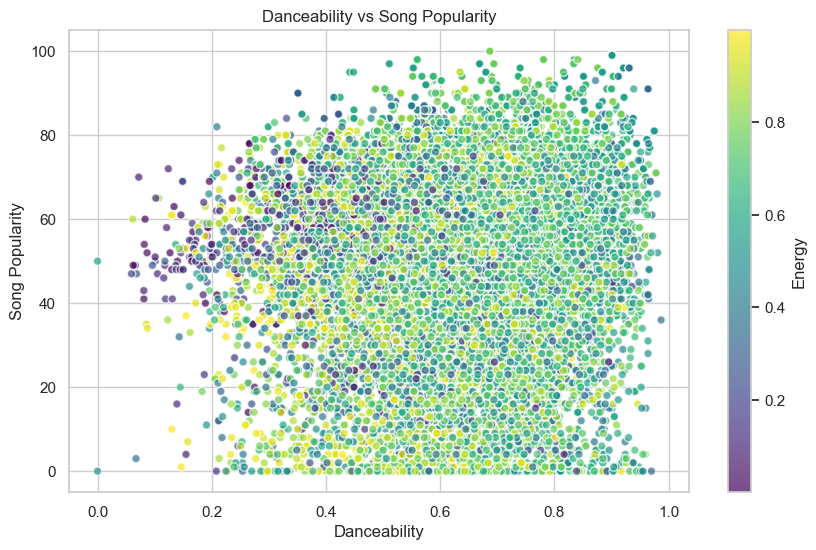

In [6]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    song_data["danceability"], 
    song_data["song_popularity"], 
    c=song_data["energy"], 
    cmap="viridis", 
    alpha=0.7, 
    edgecolor="w"
)
plt.colorbar(scatter, label="Energy")
plt.title("Danceability vs Song Popularity")
plt.xlabel("Danceability")
plt.ylabel("Song Popularity")
plt.show()

1. **Why this visualization was chosen:**  
   A scatter plot was chosen to analyze the direct relationship between danceability and song_popularity while incorporating energy as a color-coded dimension for added context.

2. **Why it’s significant for the task at hand:**  
   It helps determine whether danceability influences song popularity and highlights any combined effects of energy, offering insights into how these factors contribute to audience preferences.

3. **What we see from the result of the visualization:**  
   - Higher `danceability` values are associated with increased popularity.
   - Songs with high `energy` values tend to dominate the top popularity range, suggesting a synergy between `energy` and `danceability`.

### Pairplot for Selected Features

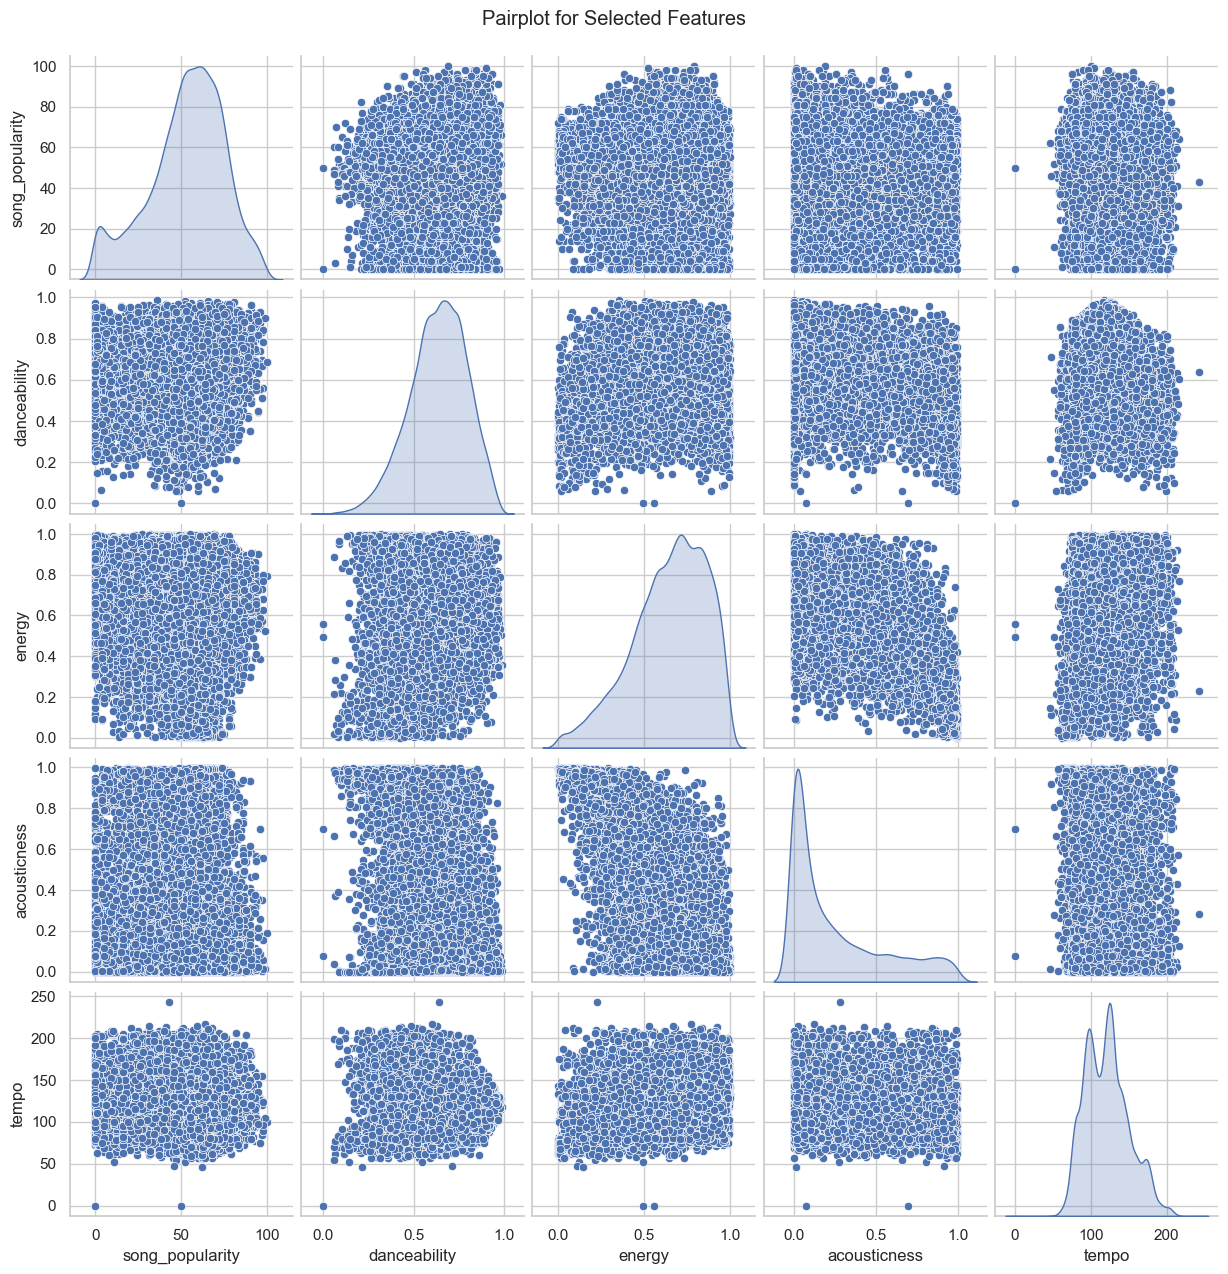

In [7]:
sns.pairplot(cleaned_data, diag_kind='kde')
plt.suptitle("Pairplot for Selected Features", y=1.02)
plt.show()

1. **Why this visualization was chosen:**  
   A pairplot was selected to explore relationships between multiple features in a single view. It shows scatter plots for pairwise relationships and distributions for individual features, providing a holistic overview.

2. **Why it’s significant for the task at hand:**  
   This visualization helps identify clusters, trends, and outliers across features simultaneously, which can inform feature engineering and data cleaning steps.

3. **What we see from the result of the visualization:**  
   - Most songs have high values of `song_popularity`, `danceability` and `energy`, low values of `acousticness` and `tempo` around 110 bpm.
   - We can see thay there are not many high `acousticness` and high `energy` songs, or high `danceability` and `tempo`.
   - The `tempo` feature seems not very indicative about `song_popularity`, which looks evenly distributed.

### Liveness vs Song Popularity

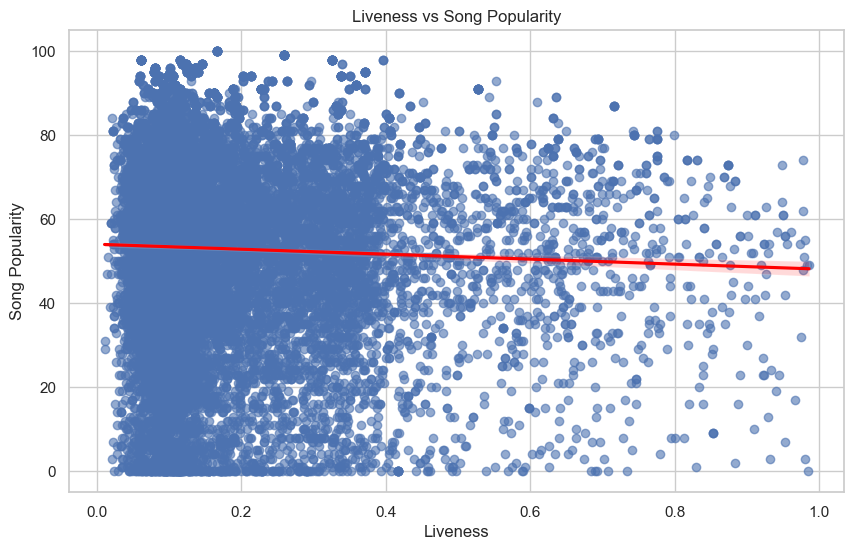

In [8]:
plt.figure(figsize=(10, 6))
sns.regplot(data=song_data, x="liveness", y="song_popularity", scatter_kws={"alpha":0.6}, line_kws={"color":"red"})
plt.title("Liveness vs Song Popularity")
plt.xlabel("Liveness")
plt.ylabel("Song Popularity")
plt.show()

1. **Why this visualization was chosen:**  
   A regression plot was used to explicitly show the trend between `liveness` and `song_popularity`, providing a visual representation of the predictive relationship.

2. **Why it’s significant for the task at hand:**  
   It quantifies the impact of `liveness` on song popularity and highlights any deviations or patterns in the data, which is vital for interpreting feature importance.

3. **What we see from the result of the visualization:**  
   - The is a weak negative trend, indicating that higher liveness values correspond to lower song popularity 
   - Most songs have lower `liveness` as live song versions are less common.

### Heatmap: Popularity by Key and Mode

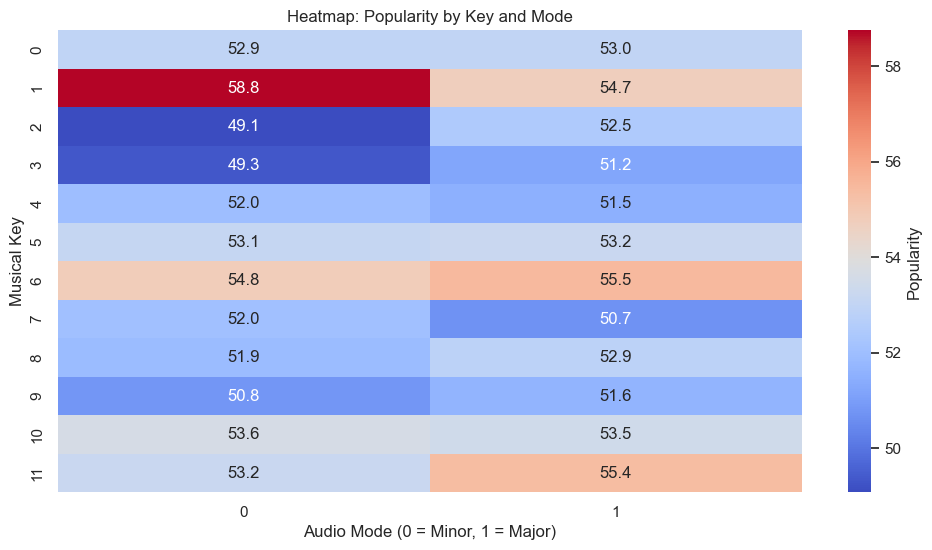

In [9]:
plt.figure(figsize=(12, 6))
heatmap_data = song_data.pivot_table(
    index="key", 
    columns="audio_mode", 
    values="song_popularity", 
    aggfunc="mean"
)
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': 'Popularity'})
plt.title("Heatmap: Popularity by Key and Mode")
plt.xlabel("Audio Mode (0 = Minor, 1 = Major)")
plt.ylabel("Musical Key")
plt.show()

1. **Why this visualization was chosen:**  
   A heatmap was chosen to visualize the relationship between two categorical variables (`Key` and `Mode`) and their combined impact on `song_popularity`. It’s ideal for comparing values across a grid.

2. **Why it’s significant for the task at hand:**  
   This visualization highlights how musical key and mode influence popularity. Such insights can guide music production or analysis by identifying combinations that resonate more with audiences.

3. **What we see from the result of the visualization:**  
   - Certain keys, such as Key 1 mode 0 (C# Minor) or key 6 mode 1 (F# Major), tend to have higher popularity.
   - The Major mode generally shows less variability in popularity, suggesting the keys are less impactful in this mode compared to the other.
   - Popularity tends to peak in specific key-mode combinations, which can indicate audience preferences for certain tonalities.

## Build and Evaluate a Basic Model

In [10]:
# Prepare data
X = song_data.drop(columns=["song_popularity", "song_name"])
y = song_data['song_popularity']

# Convert categorical columns to 'category' dtype
X["key"] = X["key"].astype("category")
X["audio_mode"] = X["audio_mode"].astype("category")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = XGBRegressor(random_state=42, enable_categorical=True)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MAE: 14.160151978244128
RMSE: 18.612108970616166


In [13]:
import pickle

# Save the trained model
with open("model_part1.pkl", "wb") as file:
    pickle.dump(model, file)

## Perform Error Analysis

Mean Error: -0.42385846343191097
Overestimated Samples: 1575
Underestimated Samples: 2192


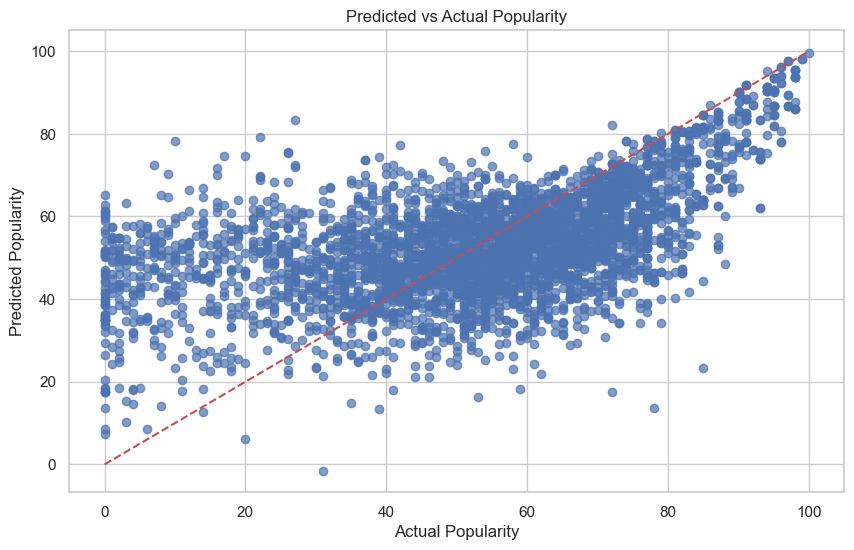

In [11]:
# Error analysis
errors = y_test - y_pred
absolute_errors = np.abs(errors)
print("Mean Error:", np.mean(errors))
print("Overestimated Samples:", sum(errors < 0))
print("Underestimated Samples:", sum(errors > 0))

# Visualize predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0, 100], [0, 100], "--r")
plt.title("Predicted vs Actual Popularity")
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.show()

The scatter plot reveals key insights into the model's performance across different popularity levels:

- **High Popularity (Above 80):**  
  For songs with a popularity score above 80, the model shows strong predictive accuracy. Points are closely aligned along the diagonal line (y = x), which indicates that the predicted popularity is nearly equal to the actual popularity. This suggests the model performs well for songs that are more popular.

- **Middle to Low Popularity (Below 80):**  
  For songs with lower to mid-range popularity scores, the model's predictions become less accurate. The points deviate more from the diagonal line, indicating larger discrepancies between predicted and actual popularity. This suggests that the model struggles with songs that are less popular, possibly due to higher variability in their features or a lack of sufficient data to generalize well.

Overall, the plot highlights that the model excels in predicting the popularity of highly popular songs, while facing challenges with less popular ones.


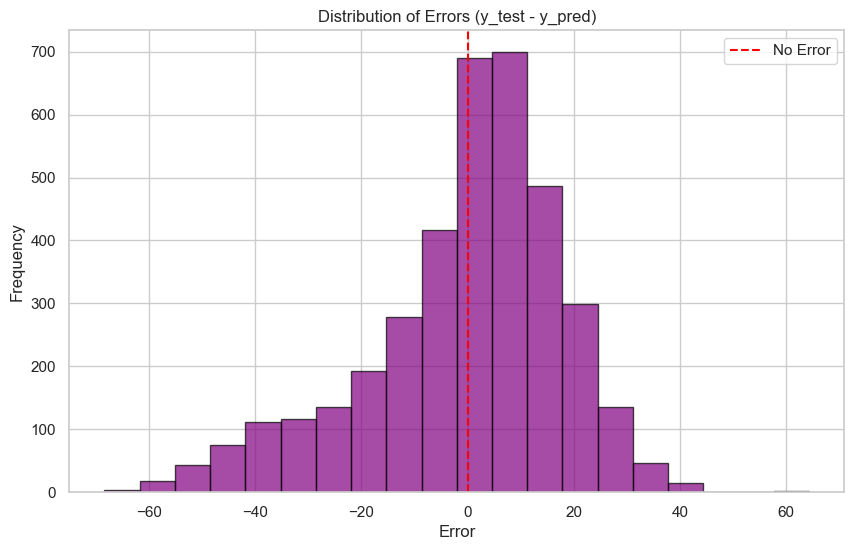

In [13]:
# Plot distribution of errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label="No Error")
plt.title("Distribution of Errors (y_test - y_pred)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The histogram of the errors reveals interesting trends regarding the model's performance:

- **Symmetry of Over/Under-Estimation:**  
  The distribution of errors shows a relatively balanced split between overestimation and underestimation. This indicates that the model's predictions are not consistently biased in one direction, and errors occur equally in both cases.

- **Variance of Underestimation:**  
  While the overestimation and underestimation are fairly balanced, underestimation exhibits higher variance. This suggests that the model tends to make larger errors when predicting lower popularity songs. The model struggles to predict the popularity of songs with lower scores, which could be due to less distinct patterns in their features, leading to less accurate predictions for this subset.

Overall, the distribution highlights the model's tendency to be less accurate for songs with lower popularity, resulting in a wider range of underestimations.

In [17]:
# Combine test data and errors for analysis
error_analysis_df = X_test.copy()
error_analysis_df["Actual"] = y_test
error_analysis_df["Predicted"] = y_pred
error_analysis_df["Error"] = errors
error_analysis_df["Absolute_Error"] = absolute_errors

sorted_error_df = error_analysis_df.sort_values("Absolute_Error", ascending=False).head(10)

styled_df = sorted_error_df.style.map(lambda x: 'background-color: yellow' if x < 0 else 'background-color: lightgreen', subset=['Error']) \
                                   .highlight_max(subset=['Predicted', 'Actual', 'Error', 'Absolute_Error'], color='lightblue') \
                                   .highlight_min(subset=['Predicted', 'Actual', 'Error', 'Absolute_Error'], color='lightcoral') \
                                   .format({'Predicted': '{:.2f}', 'Actual': '{:.2f}', 'Error': '{:.2f}', 'Absolute_Error': '{:.2f}'}) \
                                   .set_caption("Error Analysis: Predicted vs Actual Popularity")

# Examine features of samples with the highest errors
high_error_samples = error_analysis_df.sort_values("Absolute_Error", ascending=False).head(10)
styled_df

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,Actual,Predicted,Error,Absolute_Error
5887,204326,0.914000,0.326000,0.226000,0.000000,10,0.132000,-7.647000,1,0.029400,171.037000,3,0.242000,10.00,78.38,-68.38,68.38
9666,243960,0.019100,0.521000,0.752000,0.000000,11,0.068200,-5.374000,0,0.036900,105.051000,4,0.300000,7.00,72.48,-65.48,65.48
9437,210306,0.116000,0.691000,0.739000,0.000000,0,0.156000,-5.453000,1,0.030100,115.024000,4,0.492000,0.00,65.23,-65.23,65.23
10347,237240,0.036700,0.540000,0.367000,0.000000,0,0.043300,-14.238000,1,0.027700,70.276000,4,0.252000,78.00,13.69,64.31,64.31
17571,259040,0.048300,0.673000,0.671000,0.000000,11,0.336000,-5.156000,0,0.228000,155.695000,4,0.828000,0.00,62.78,-62.78,62.78
8698,220306,0.015100,0.884000,0.346000,0.000007,8,0.087100,-8.228000,0,0.351000,75.016000,4,0.376000,85.00,23.41,61.59,61.59
2522,234240,0.009030,0.764000,0.759000,0.000000,1,0.074600,-5.443000,0,0.041300,128.999000,4,0.937000,9.00,70.34,-61.34,61.34
9982,221322,0.026700,0.447000,0.812000,0.000000,0,0.132000,-5.356000,1,0.060900,145.163000,4,0.465000,0.00,61.27,-61.27,61.27
9450,253000,0.000499,0.297000,0.960000,0.006450,2,0.110000,-3.234000,1,0.156000,115.206000,4,0.193000,0.00,61.22,-61.22,61.22
6415,283680,0.011900,0.612000,0.665000,0.000000,11,0.092800,-4.519000,0,0.029200,99.989000,4,0.384000,0.00,60.57,-60.57,60.57


The top 10 samples with the highest absolute errors reveal an interesting pattern:

- **Popularity**: 8 out of 10 of these songs have low popularity scores, indicating that the model struggles more with predicting the popularity of less popular songs.
  
- **Acousticness**: 9 out of 10 songs exhibit very low acousticness, while the remaining song has high acousticness. This suggests that the model might have difficulty in predicting popularity for songs with extreme acousticness values, whether low or high.

This analysis highlights potential areas where the model could be improved, particularly in handling songs with either very low or very high acousticness.


<Figure size 1000x600 with 0 Axes>

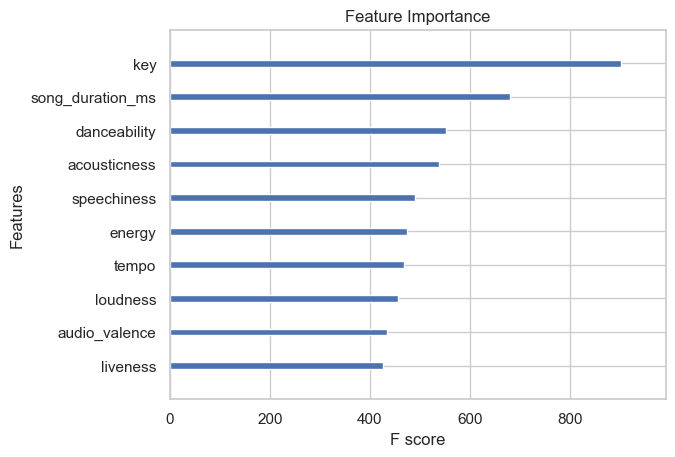

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type="weight", show_values=False)
plt.title("Feature Importance")
plt.show()

- The **feature importance plot** highlights that the feature *'key'* has a **high importance** score, suggesting that it contributes significantly to the model's predictions.
  
- However, this finding is **contradicted by the correlation graph**, where *'key'* shows a **low correlation** with the target variable (song popularity). 

This discrepancy points to a potential issue: while the model assigns high importance to the *'key'* feature, its **actual relationship with popularity** is weak. This could lead to misleading conclusions, as the model might overvalue a feature that has little real predictive power.

This insight suggests the need for further analysis to ensure that the model is interpreting features in a way that reflects their true influence on the target.
